<a href="https://colab.research.google.com/github/daigo0927/pwcnet/blob/feature%2Fdataset/test_components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup environment

## Clone develop branch

In [1]:
! git clone -b feature/dataset https://github.com/daigo0927/pwcnet.git

fatal: destination path 'pwcnet' already exists and is not an empty directory.


## Install dependent libraries

In [2]:
! pip install -U tensorflow tensorflow-addons 

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)
Requirement already up-to-date: tensorflow-addons in /usr/local/lib/python3.6/dist-packages (0.8.3)


## Change directory

In [3]:
%cd pwcnet/pwcnet
%ls 

/content/pwcnet/pwcnet
datasets.py  flow_vis.py  __pycache__/


## Import libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from functools import partial
from datasets import (
    normalize,
    random_crop,
    random_horizontal_flip, hflip,
    random_vertical_flip, vflip,
)
from flow_vis import flow_to_color, flow_to_quiver, show_image_and_flow

# Create sample data

## Visualize the optical flow color palette

fx
 [[-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]
 ...
 [-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]
 [-16 -15 -14 ...  13  14  15]]
fy
 [[-16 -16 -16 ... -16 -16 -16]
 [-15 -15 -15 ... -15 -15 -15]
 [-14 -14 -14 ... -14 -14 -14]
 ...
 [ 13  13  13 ...  13  13  13]
 [ 14  14  14 ...  14  14  14]
 [ 15  15  15 ...  15  15  15]]


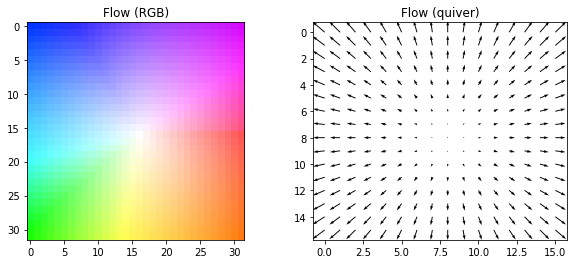

In [25]:
w, h = 32, 32
f = np.arange(-16, 16)
fx = np.tile(f.reshape(1, -1), reps=[h, 1])
fy = np.tile(f.reshape(-1, 1), reps=[1, w])
print('fx\n', fx)
print('fy\n', fy)

flow_sample = np.stack([fx, fy], axis=-1)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
flow_rgb = flow_to_color(flow_sample)
ax1.set_title('Flow (RGB)')
ax1.imshow(flow_rgb)

ax2 = fig.add_subplot(122)
flow_quiver = flow_to_quiver(flow_sample[::2, ::2])
ax2.set_title('Flow (quiver)')
ax2.quiver(*flow_quiver, angles='xy')
ax2.set_ylim(ax2.get_ylim()[::-1])

plt.show()

## Define pre/post-warp image (cyclic warp)

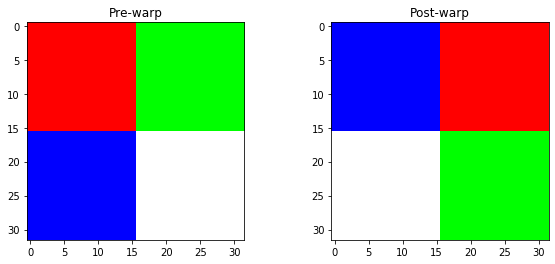

In [26]:
image1_origin = np.zeros((32, 32, 3), dtype=np.uint8)
image1_origin[:16, :16, 0] = 255 # top-left: red
image1_origin[:16, 16:, 1] = 255 # top-right: green
image1_origin[16:, :16, 2] = 255 # bottom-left: blue
image1_origin[16:, 16:, :] = 255 # bottom-right: white

image2_origin = np.zeros((32, 32, 3), dtype=np.uint8)
image2_origin[:16, :16, 2] = 255 # top-left: red
image2_origin[:16, 16:, 0] = 255 # top-right: green
image2_origin[16:, :16, :] = 255 # bottom-left: blue
image2_origin[16:, 16:, 1] = 255 # bottom-right: white

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title('Pre-warp')
ax1.imshow(image1_origin)

ax2 = fig.add_subplot(122)
ax2.set_title('Post-warp')
ax2.imshow(image2_origin)

plt.show()

## Define optical flow (cyclic)

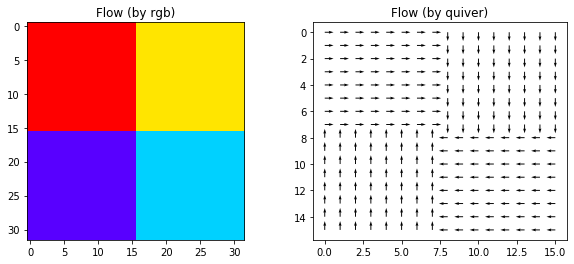

In [27]:
flow_origin = np.zeros((32, 32, 2), dtype=np.float32)
flow_origin[:16, :16, 0] = 16 # red (top-left) -> right
flow_origin[:16, 16:, 1] = 16 # green (top-right) -> bottom
flow_origin[16:, 16:, 0] = -16 # white (bottom-right) -> left
flow_origin[16:, :16, 1] = -16 # blue (bottom-left) -> top

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title('Flow (by rgb)')
ax1.imshow(flow_to_color(flow_origin))

ax2 = fig.add_subplot(122)
ax2.set_title('Flow (by quiver)')
ax2.quiver(*flow_to_quiver(flow_origin[::2, ::2]), angles='xy')
ax2.set_ylim(ax2.get_ylim()[::-1])

plt.show()

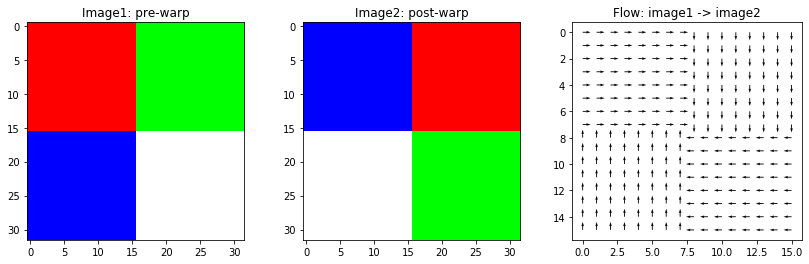

In [28]:
show_image_and_flow(image1_origin, image2_origin, flow_origin[::2, ::2])

# Validate preprocessing function

## Prepare initial tf.data.Dataset object

In [0]:
images1_origin = [image1_origin for i in range(10)]
images2_origin = [image2_origin for i in range(10)]
flows_origin = [flow_origin for i in range(10)]
dataset = tf.data.Dataset.from_tensor_slices((images1_origin, images2_origin, flows_origin))

## Run preprocessings

### Normalization

In [32]:
flow_scaler = 20
ds = dataset.map(partial(normalize, flow_scaler=flow_scaler))
im1, im2, flo = list(ds.as_numpy_iterator())[0]

print(f'Original stats: {image1_origin.max(), image2_origin.max(), flow_origin.max()}')
print(f'Processed stats: {im1.max(), im2.max(), flo.max()}')

Original stats: (255, 255, 16.0)
Processed stats: (1.0, 1.0, 0.8)


### Random crop

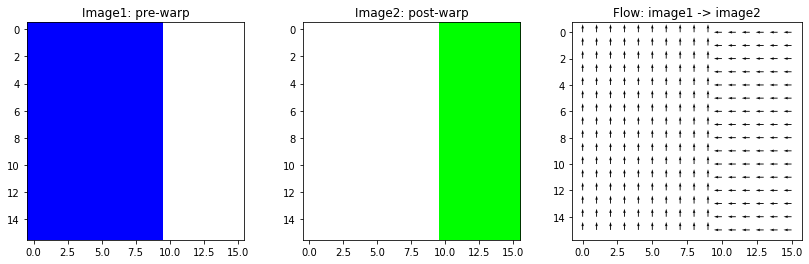

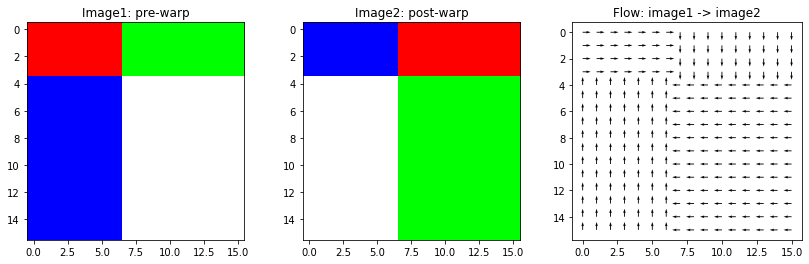

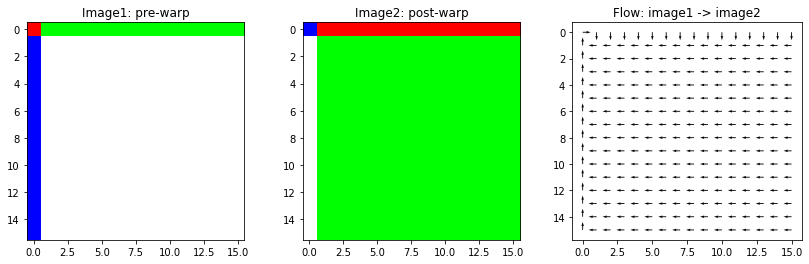

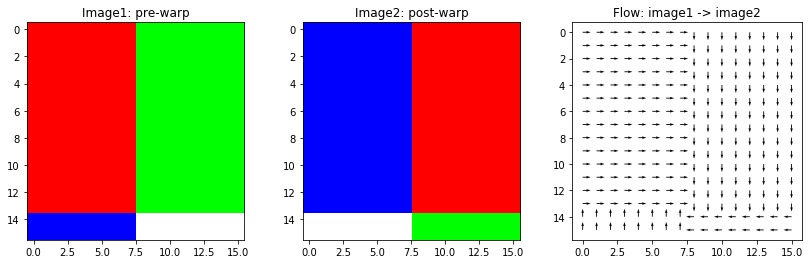

In [33]:
target_size = (16, 16)
ds_crop = ds.map(partial(random_crop, target_size=target_size))

for image1, image2, flow in ds_crop.take(4):
    show_image_and_flow(image1, image2, flow)

### Horizontal flip

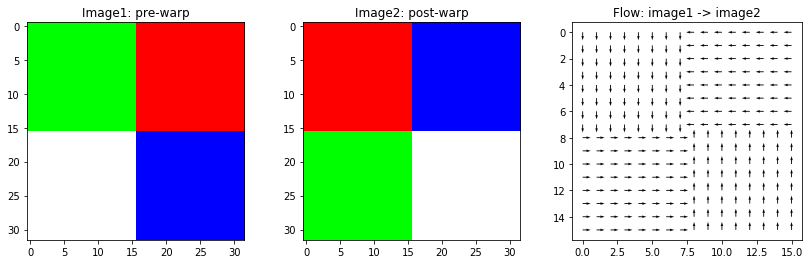

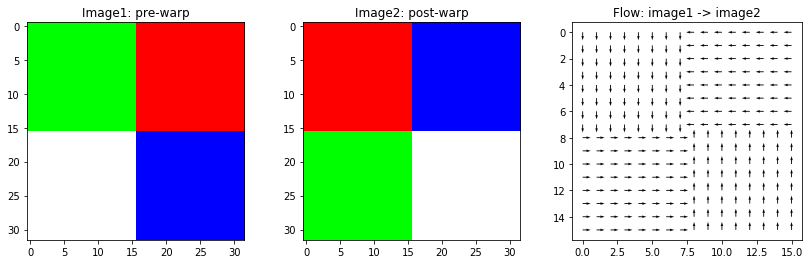

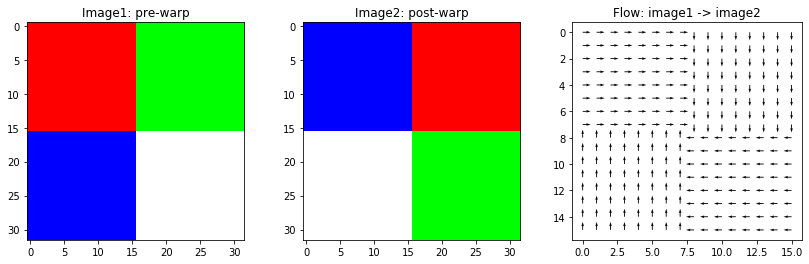

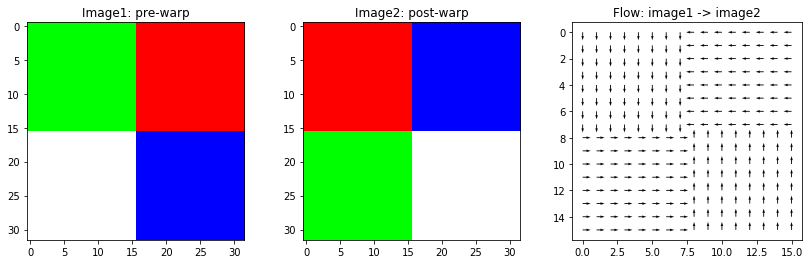

In [34]:
ds_hflip = ds.map(random_horizontal_flip)

for image1, image2, flow in ds_hflip.take(4):
    show_image_and_flow(image1, image2, flow[::2, ::2])

### Vertical flip

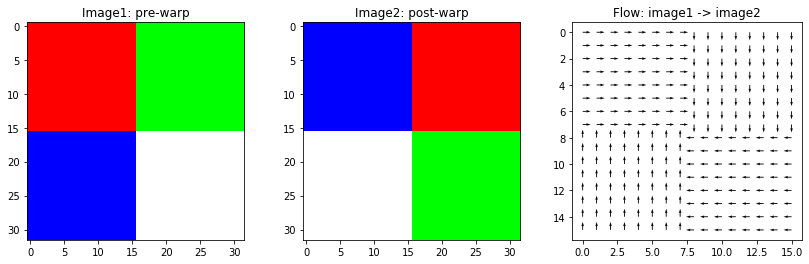

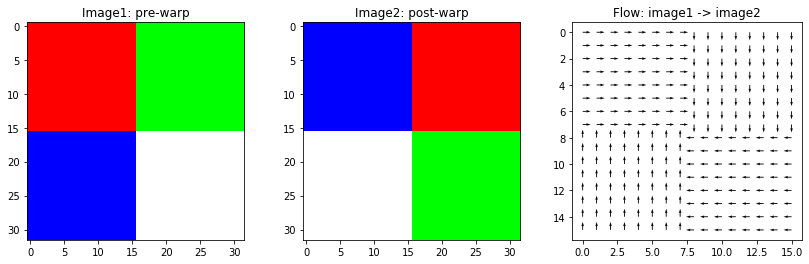

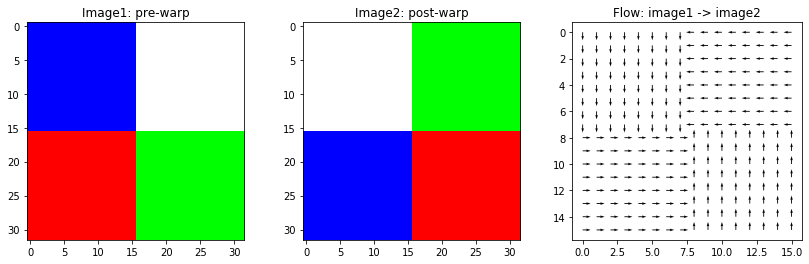

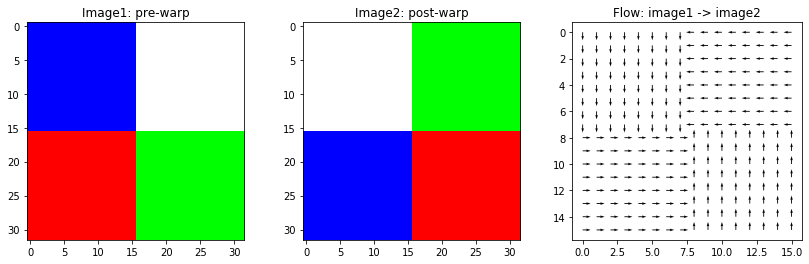

In [38]:
ds_vflip = ds.map(random_vertical_flip)

for image1, image2, flow in ds_vflip.take(4):
    show_image_and_flow(image1, image2, flow[::2, ::2])

# Validate Warping function

## Define warping function

In [0]:
def get_grid(x):
    batch_size, height, width, filters = tf.unstack(tf.shape(x))
    Bg, Yg, Xg = tf.meshgrid(tf.range(batch_size), tf.range(height), tf.range(width),
                             indexing = 'ij')
    return Bg, Yg, Xg

def nearest_warp(x, flow):
    grid_b, grid_y, grid_x = get_grid(x)
    flow = tf.cast(flow, tf.int32)

    warped_gy = tf.add(grid_y, flow[:,:,:,1]) # flow_y
    warped_gx = tf.add(grid_x, flow[:,:,:,0]) # flow_x
    # clip value by height/width limitation
    _, h, w, _ = tf.unstack(tf.shape(x))
    warped_gy = tf.clip_by_value(warped_gy, 0, h-1)
    warped_gx = tf.clip_by_value(warped_gx, 0, w-1)
            
    warped_indices = tf.stack([grid_b, warped_gy, warped_gx], axis = 3)
            
    warped_x = tf.gather_nd(x, warped_indices)
    return warped_x

def bilinear_warp(x, flow):
    _, h, w, _ = tf.unstack(tf.shape(x))
    grid_b, grid_y, grid_x = get_grid(x)
    grid_b = tf.cast(grid_b, tf.float32)
    grid_y = tf.cast(grid_y, tf.float32)
    grid_x = tf.cast(grid_x, tf.float32)

    flow = tf.cast(flow, tf.float32)
    fx, fy = tf.unstack(flow, axis = -1)
    fx_0 = tf.floor(fx)
    fx_1 = fx_0+1
    fy_0 = tf.floor(fy)
    fy_1 = fy_0+1

    # warping indices
    h_lim = tf.cast(h-1, tf.float32)
    w_lim = tf.cast(w-1, tf.float32)
    gy_0 = tf.clip_by_value(grid_y + fy_0, 0., h_lim)
    gy_1 = tf.clip_by_value(grid_y + fy_1, 0., h_lim)
    gx_0 = tf.clip_by_value(grid_x + fx_0, 0., w_lim)
    gx_1 = tf.clip_by_value(grid_x + fx_1, 0., w_lim)
    
    g_00 = tf.cast(tf.stack([grid_b, gy_0, gx_0], axis = 3), tf.int32)
    g_01 = tf.cast(tf.stack([grid_b, gy_0, gx_1], axis = 3), tf.int32)
    g_10 = tf.cast(tf.stack([grid_b, gy_1, gx_0], axis = 3), tf.int32)
    g_11 = tf.cast(tf.stack([grid_b, gy_1, gx_1], axis = 3), tf.int32)

    # gather contents
    x = tf.cast(x, tf.float32)
    x_00 = tf.gather_nd(x, g_00)
    x_01 = tf.gather_nd(x, g_01)
    x_10 = tf.gather_nd(x, g_10)
    x_11 = tf.gather_nd(x, g_11)

    # coefficients
    c_00 = tf.expand_dims((fy_1 - fy)*(fx_1 - fx), axis = 3)
    c_01 = tf.expand_dims((fy_1 - fy)*(fx - fx_0), axis = 3)
    c_10 = tf.expand_dims((fy - fy_0)*(fx_1 - fx), axis = 3)
    c_11 = tf.expand_dims((fy - fy_0)*(fx - fx_0), axis = 3)

    return c_00*x_00 + c_01*x_01 + c_10*x_10 + c_11*x_11

## Run warping function

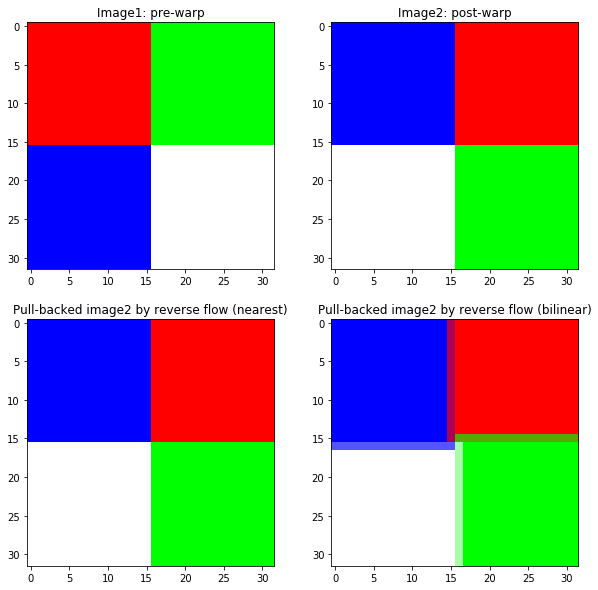

In [37]:
image2_batch = tf.expand_dims(tf.convert_to_tensor(image2), axis=0)
flow_batch = tf.expand_dims(tf.convert_to_tensor(flow)/1.2, axis=0)
warped_nearest = nearest_warp(image2_batch, flow_batch).numpy()[0]
warped_bilinear = bilinear_warp(image2_batch, flow_batch).numpy()[0]

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax1.set_title('Image1: pre-warp')
ax1.imshow(image1)

ax2 = fig.add_subplot(222)
ax2.set_title('Image2: post-warp')
ax2.imshow(image2)

ax3 = fig.add_subplot(223)
ax3.set_title('Pull-backed image2 by reverse flow (nearest)')
ax3.imshow(warped_nearest)

ax4 = fig.add_subplot(224)
ax4.set_title('Pull-backed image2 by reverse flow (bilinear)')
ax4.imshow(warped_bilinear)

plt.show()